## Introduction

In this article we are going to look into how you can track various experiments using Tensorboard in PyTorch and use the tracking data to tune hyperparameters. First let us see what is experiment tracking and hyperparameter tuning. 

### Experiment Tracking

Experiment tracking refers to the process of collecting and organizing data related to machine learning experiments. It involves logging and monitoring various aspects of an experiment, such as the model architecture, hyperparameters, training progress, evaluation metrics, and visualizations.

Experiment tracking helps researchers and practitioners keep a record of their experiments, making it easier to reproduce and compare results. It enables better understanding of the experiment's behavior, aids in debugging, and facilitates collaboration within teams.

One popular tool for experiment tracking is TensorBoard, which is a web-based visualization tool provided by TensorFlow. While originally developed for TensorFlow, it can also be used with PyTorch, another popular deep learning framework.

TensorBoard provides a user-friendly interface to explore and analyze experiment data. It allows visualizing metrics like loss and accuracy over time, examining the model graph, visualizing histograms of weights and biases, and displaying images and embeddings. It also supports interactive visualizations such as 3D embeddings and custom plots.

By using TensorBoard, you can gain insights into your experiments, compare different models or hyperparameter settings, and make informed decisions for improving your machine learning models.

### Hyper Parameter Tuning
Hyperparameter tuning, also known as hyperparameter optimization, is the process of finding the optimal values for the hyperparameters of a machine learning model. Hyperparameters are configuration settings that are not learned from the data but are set prior to training and affect the learning process.

Examples of hyperparameters include learning rate, batch size, number of hidden layers, number of units in each layer, regularization parameters, and activation functions. The choice of hyperparameters can significantly impact the performance and generalization ability of a model.

Hyperparameter tuning is crucial because selecting appropriate values for hyperparameters can lead to better model performance. It involves systematically searching through a predefined space of possible hyperparameter values to find the combination that yields the best results.

There are several strategies for hyperparameter tuning, including:

1. Manual search: This involves manually selecting hyperparameter values based on prior knowledge, intuition, or trial and error. It is a simple approach but can be time-consuming and may not yield the best results.
2. Grid search: Grid search involves defining a grid of possible hyperparameter values and exhaustively searching through all combinations. It evaluates and compares models trained with each combination of hyperparameters. While it guarantees finding the best hyperparameter values within the defined grid, it can be computationally expensive when the search space is large.
3. Random search: Random search selects hyperparameter values randomly from a predefined distribution. It performs a specified number of random searches and evaluates the models trained with each set of hyperparameters. Random search is more efficient than grid search when the search space is large and it doesn't require exhaustive evaluation of all combinations.
4. Bayesian optimization: Bayesian optimization is an advanced technique that uses probabilistic models to predict the performance of different hyperparameter settings. It iteratively explores the search space by evaluating a few carefully selected points and updating the probabilistic model. Bayesian optimization can be more efficient than random search or grid search when the search space is large and expensive to evaluate.
5. Automated techniques: There are automated hyperparameter tuning techniques like genetic algorithms, evolutionary algorithms, and reinforcement learning-based approaches that aim to optimize hyperparameters automatically. These techniques use optimization algorithms to search the hyperparameter space based on fitness evaluation.

During hyperparameter tuning, it is common to use evaluation metrics such as accuracy, precision, recall, or mean squared error to assess the performance of the models trained with different hyperparameter values.

By tuning hyperparameters effectively, you can improve the performance and generalization of your machine learning models, leading to better results on unseen data. Experiment tracking tools like TensorBoard can be valuable in this process, as they allow you to monitor and compare the performance of different hyperparameter settings over time.

For this demonstration we will be using the simple but expensive grid search. In the later blogs I will show you how we can implement the other hyperparameter tuning algorithms. 

We will use the FashionMNIST dataset and tune the hyperparamters of our custom VGG model using Grid Search. 

Let's begin.

## Install and Import Dependencies

In [38]:
%pip install -q torchinfo torchmetrics tensorboard

Note: you may need to restart the kernel to use updated packages.


In [39]:
import torch
import torchvision
import os
from torchvision.transforms import Resize, Compose, ToTensor
import matplotlib.pyplot as plt
from torchinfo import summary
import torchmetrics
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

device = "cuda" if torch.cuda.is_available() else "cpu"

## Load the Dataset and Dataloader

In [41]:
BATCH_SIZE = 64

if not os.path.exists("data"): os.mkdir("data")

train_transform = Compose([Resize((64,64)),
                           ToTensor()
                           ])
test_transform = Compose([Resize((64,64)),
                          ToTensor()
                          ])


training_dataset = torchvision.datasets.FashionMNIST(root = "data",
                                                     download = True,
                                                     train = True,
                                                     transform = train_transform)

test_dataset = torchvision.datasets.FashionMNIST(root = "data",
                                                 download = True,
                                                 train = False,
                                                 transform = test_transform)

train_dataloader = torch.utils.data.DataLoader(training_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=2
                                          )

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size = BATCH_SIZE,
                                              shuffle = False,
                                              num_workers = 2
                                              )

Let us see how many examples are there in the training set and the test set

In [42]:
print(f"Number of Images in test dataset is {len(test_dataset)}")
print(f"Number of Images in training dataset is {len(training_dataset)}")

Number of Images in test dataset is 10000
Number of Images in training dataset is 60000


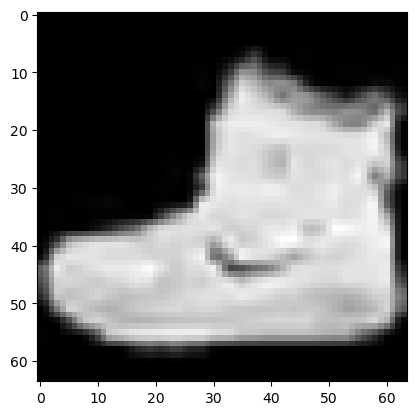

In [43]:
plt.imshow(training_dataset[0][0].permute((1,2,0)), cmap = "gray")
plt.axis("off")

## Create a TinyVGG Model

In [44]:
import torch.nn as nn

class TinyVGG(nn.Module):
    """
    A small VGG-like network for image classification.

    Args:
        in_channels (int): The number of input channels.
        n_classes (int): The number of output classes.
        hidden_units (int): The number of hidden units in each convolutional block.
        n_conv_blocks (int): The number of convolutional blocks.
        dropout (float): The dropout rate.
    """

    def __init__(self, in_channels, n_classes, hidden_units, n_conv_blocks, dropout):
        super().__init__()
        self.in_channels = in_channels
        self.out_features = n_classes
        self.dropout = dropout
        self.hidden_units = hidden_units

        # Input block
        self.input_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, padding=0, stride=1),
            nn.Dropout(dropout),
            nn.ReLU(),
        )

        # Convolutional blocks
        self.conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=0, stride=1),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ) for _ in range(n_conv_blocks)
        ])

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(out_features=256),
            nn.Dropout(dropout),
            nn.Linear(in_features=256, out_features=64),
            nn.Linear(in_features=64, out_features=n_classes),
        )

    def forward(self, x):
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.
        """

        x = self.input_block(x)
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        x = self.classifier(x)
        return x

In [45]:
model =  TinyVGG(in_channels = 1,
                 n_classes = len(training_dataset.classes),
                 hidden_units = 64,
                 n_conv_blocks = 3,
                 dropout = 0.1).to(device)
summary(model, [1,64,64], batch_dim = 1)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Sequential: 2-1                   [1, 64, 62, 62]           --
│    │    └─Conv2d: 3-1                  [1, 64, 62, 62]           640
│    │    └─Dropout: 3-2                 [1, 64, 62, 62]           --
│    │    └─ReLU: 3-3                    [1, 64, 62, 62]           --
│    └─Sequential: 2-2                   [1, 64, 30, 30]           --
│    │    └─Conv2d: 3-4                  [1, 64, 60, 60]           36,928
│    │    └─Dropout: 3-5                 [1, 64, 60, 60]           --
│    │    └─ReLU: 3-6                    [1, 64, 60, 60]           --
│    │    └─MaxPool2d: 3-7               [1, 64, 30, 30]           --
│    └─Sequential: 2-3                   [1, 64, 14, 14]           (recursive)
│    │    └─Conv2d: 3-8                  [1, 64, 28, 28]           (rec

In [46]:

def train_step(dataloader, model, optimizer, criterion, device, train_acc_metric):
    """
    Perform a single training step.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader for the training data.
        model (torch.nn.Module): The model to train.
        optimizer (torch.optim.Optimizer): The optimizer for the model.
        criterion (torch.nn.Module): The loss function for the model.
        device (torch.device): The device to train the model on.
        train_acc_metric (torchmetrics.Accuracy): The accuracy metric for the model.

    Returns:
        The accuracy of the model on the training data.
    """

    for (X, y) in tqdm.tqdm(dataloader):
        # Move the data to the device.
        X = X.to(device)
        y = y.to(device)

        # Forward pass.
        y_preds = model(X)

        # Calculate the loss.
        loss = criterion(y_preds, y)

        # Calculate the accuracy.
        train_acc_metric.update(y_preds, y)

        # Backpropagate the loss.
        loss.backward()

        # Update the parameters.
        optimizer.step()

        # Zero the gradients.
        optimizer.zero_grad()

    return train_acc_metric.compute()


In [47]:
def test_step(dataloader, model, device, test_acc_metric):
    """
    Perform a single test step.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader for the test data.
        model (torch.nn.Module): The model to test.
        device (torch.device): The device to test the model on.
        test_acc_metric (torchmetrics.Accuracy): The accuracy metric for the model.

    Returns:
        The accuracy of the model on the test data.
    """

    for (X, y) in tqdm.tqdm(dataloader):
        # Move the data to the device.
        X = X.to(device)
        y = y.to(device)

        # Forward pass.
        y_preds = model(X)

        # Calculate the accuracy.
        test_acc_metric.update(y_preds, y)

    return test_acc_metric.compute()



In [48]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
criterion = torch.nn.CrossEntropyLoss()

Here, there are several hyperparameters as you can see - Learning Rate, Number of Epochs, type of optimizer, number of convolution layers, dropout and number of hidden units. We can first fix the learning rate and number of epoch and try to find the best number of convolution layers, dropout and hidden units. Once we have those we can then tune the number of epochs and learning rate. 

In [49]:

EPOCHS = 10
LEARNING_RATE = 0.001

In [50]:
from datetime import datetime

def create_writer(
    experiment_name: str, model_name: str, conv_layers, dropout, hidden_units
) -> SummaryWriter:
    """
    Create a SummaryWriter object for logging the training and test results.

    Args:
        experiment_name (str): The name of the experiment.
        model_name (str): The name of the model.
        conv_layers (int): The number of convolutional layers in the model.
        dropout (float): The dropout rate used in the model.
        hidden_units (int): The number of hidden units in the model.

    Returns:
        SummaryWriter: The SummaryWriter object.
    """

    timestamp = str(datetime.now().strftime("%d-%m-%Y_%H-%M-%S"))
    log_dir = os.path.join(
        "runs",
        timestamp,
        experiment_name,
        model_name,
        f"{conv_layers}",
        f"{dropout}",
        f"{hidden_units}",
    ).replace("\\", "/")
    return SummaryWriter(log_dir=log_dir)

## Hyper Parameter Tuning

In [51]:
"""
This code performs hyperparameter tuning for a TinyVGG model.

The hyperparameters that are tuned are the number of convolutional layers, the dropout rate, and the number of hidden units.

The results of the hyperparameter tuning are logged to a TensorBoard file.
"""

experiment_number = 0

# hyperparameters to tune
hparams_config = {
    "n_conv_layers": [1, 2, 3],
    "dropout": [0.0, 0.25, 0.5],
    "hidden_units": [128, 256, 512],
}

for n_conv_layers in hparams_config["n_conv_layers"]:
    for dropout in hparams_config["dropout"]:
        for hidden_units in hparams_config["hidden_units"]:
            experiment_number += 1
            print(
                f"\nTuning Hyper Parameters || Conv Layers: {n_conv_layers} || Dropout: {dropout} || Hidden Units: {hidden_units} \n"
            )

            # create the model
            model = TinyVGG(
                in_channels=1,
                n_classes=len(training_dataset.classes),
                hidden_units=hidden_units,
                n_conv_blocks=n_conv_layers,
                dropout=dropout,
            ).to(device)

            # create the optimizer and loss function
            optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
            criterion = torch.nn.CrossEntropyLoss()

            # create the accuracy metrics
            train_acc_metric = torchmetrics.Accuracy(
                task="multiclass", num_classes=len(training_dataset.classes)
            ).to(device)
            test_acc_metric = torchmetrics.Accuracy(
                task="multiclass", num_classes=len(training_dataset.classes)
            ).to(device)

            # create the TensorBoard writer
            writer = create_writer(
                experiment_name=f"{experiment_number}",
                model_name="tiny_vgg",
                conv_layers=n_conv_layers,
                dropout=dropout,
                hidden_units=hidden_units,
            )

            # train the model
            for epoch in range(EPOCHS):
                train_step(
                    train_dataloader,
                    model,
                    optimizer,
                    criterion,
                    device,
                    train_acc_metric,
                )
                test_step(test_dataloader, model, device, test_acc_metric)
                writer.add_scalar(
                    tag="Training Accuracy",
                    scalar_value=train_acc_metric.compute(),
                    global_step=epoch,
                )
                writer.add_scalar(
                    tag="Test Accuracy",
                    scalar_value=test_acc_metric.compute(),
                    global_step=epoch,
                )

            # add the hyperparameters and metrics to TensorBoard
            writer.add_hparams(
                {
                    "conv_layers": n_conv_layers,
                    "dropout": dropout,
                    "hidden_units": hidden_units,
                },
                {
                    "train_acc": train_acc_metric.compute(),
                    "test_acc": test_acc_metric.compute(),
                },
            )


 Tuning Hyper Parameters || Conv Layers: 2 || Dropout: 0.1 || Hidden Units: 32 



100%|██████████| 938/938 [00:10<00:00, 89.13it/s] 


train_acc = 0.8325999975204468


100%|██████████| 157/157 [00:02<00:00, 76.67it/s] 


test_acc = 0.862500011920929


100%|██████████| 938/938 [00:10<00:00, 91.80it/s] 


train_acc = 0.8614083528518677


100%|██████████| 157/157 [00:02<00:00, 77.59it/s] 


test_acc = 0.8751999735832214


100%|██████████| 938/938 [00:10<00:00, 91.45it/s] 


train_acc = 0.8762277960777283


100%|██████████| 157/157 [00:02<00:00, 75.34it/s] 


test_acc = 0.8844333291053772


100%|██████████| 938/938 [00:10<00:00, 91.48it/s] 


train_acc = 0.8858208060264587


100%|██████████| 157/157 [00:02<00:00, 78.04it/s] 


test_acc = 0.8885250091552734


100%|██████████| 938/938 [00:10<00:00, 92.42it/s] 


train_acc = 0.8926533460617065


100%|██████████| 157/157 [00:02<00:00, 77.00it/s] 


test_acc = 0.8917199969291687


100%|██████████| 938/938 [00:10<00:00, 92.91it/s] 


train_acc = 0.8980333209037781


100%|██████████| 157/157 [00:02<00:00, 76.99it/s] 


test_acc = 0.8946499824523926


100%|██████████| 938/938 [00:10<00:00, 92.50it/s] 


train_acc = 0.9025428295135498


100%|██████████| 157/157 [00:02<00:00, 76.34it/s] 


test_acc = 0.8966857194900513


100%|██████████| 938/938 [00:10<00:00, 92.55it/s] 


train_acc = 0.9064124822616577


100%|██████████| 157/157 [00:02<00:00, 77.62it/s] 


test_acc = 0.8982250094413757


100%|██████████| 938/938 [00:10<00:00, 92.29it/s] 


train_acc = 0.9097962975502014


100%|██████████| 157/157 [00:02<00:00, 77.96it/s] 


test_acc = 0.8989889025688171


100%|██████████| 938/938 [00:10<00:00, 92.84it/s] 


train_acc = 0.9127333164215088


100%|██████████| 157/157 [00:02<00:00, 77.66it/s] 


test_acc = 0.8992199897766113

 Tuning Hyper Parameters || Conv Layers: 2 || Dropout: 0.1 || Hidden Units: 64 



100%|██████████| 938/938 [00:18<00:00, 49.87it/s]


train_acc = 0.8479166626930237


100%|██████████| 157/157 [00:02<00:00, 63.93it/s] 


test_acc = 0.8844000101089478


100%|██████████| 938/938 [00:18<00:00, 50.14it/s]


train_acc = 0.8754249811172485


100%|██████████| 157/157 [00:02<00:00, 63.76it/s] 


test_acc = 0.8926500082015991


100%|██████████| 938/938 [00:18<00:00, 50.18it/s]


train_acc = 0.8885111212730408


100%|██████████| 157/157 [00:02<00:00, 63.24it/s] 


test_acc = 0.8987666964530945


100%|██████████| 938/938 [00:18<00:00, 49.59it/s]


train_acc = 0.8973166942596436


100%|██████████| 157/157 [00:02<00:00, 63.97it/s] 


test_acc = 0.9006249904632568


100%|██████████| 938/938 [00:18<00:00, 49.43it/s]


train_acc = 0.9044533371925354


100%|██████████| 157/157 [00:02<00:00, 64.45it/s] 


test_acc = 0.9036800265312195


100%|██████████| 938/938 [00:18<00:00, 50.40it/s]


train_acc = 0.9098583459854126


100%|██████████| 157/157 [00:02<00:00, 63.45it/s] 


test_acc = 0.9048166871070862


100%|██████████| 938/938 [00:18<00:00, 50.34it/s]


train_acc = 0.9143785834312439


100%|██████████| 157/157 [00:02<00:00, 63.84it/s] 


test_acc = 0.9058571457862854


100%|██████████| 938/938 [00:18<00:00, 50.73it/s]


train_acc = 0.9182083606719971


100%|██████████| 157/157 [00:02<00:00, 63.69it/s] 


test_acc = 0.9064750075340271


100%|██████████| 938/938 [00:18<00:00, 50.25it/s]


train_acc = 0.921583354473114


100%|██████████| 157/157 [00:02<00:00, 63.52it/s] 


test_acc = 0.9067777991294861


100%|██████████| 938/938 [00:18<00:00, 49.94it/s]


train_acc = 0.9245749711990356


100%|██████████| 157/157 [00:02<00:00, 63.73it/s] 


test_acc = 0.9075700044631958

 Tuning Hyper Parameters || Conv Layers: 2 || Dropout: 0.1 || Hidden Units: 128 



100%|██████████| 938/938 [00:34<00:00, 27.57it/s]


train_acc = 0.840399980545044


100%|██████████| 157/157 [00:03<00:00, 46.25it/s]


test_acc = 0.885200023651123


100%|██████████| 938/938 [00:33<00:00, 27.70it/s]


train_acc = 0.8692416548728943


100%|██████████| 157/157 [00:03<00:00, 46.68it/s]


test_acc = 0.8912000060081482


100%|██████████| 938/938 [00:33<00:00, 27.69it/s]


train_acc = 0.8827278017997742


100%|██████████| 157/157 [00:03<00:00, 46.66it/s]


test_acc = 0.8953666687011719


 67%|██████▋   | 631/938 [00:23<00:10, 28.80it/s]

In [ ]:
model =  TinyVGG(in_channels = 1,
n_classes = len(training_dataset.classes),
hidden_units = 32,
n_conv_blocks = 2,
dropout = 0.2).to(device)

optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

train_acc_metric = torchmetrics.Accuracy(task="multiclass",
                                    num_classes=len(training_dataset.classes)).to(device)
test_acc_metric = torchmetrics.Accuracy(task="multiclass",
                                    num_classes=len(training_dataset.classes)).to(device)

